<a href="https://colab.research.google.com/github/xinconggg/Machine-Learning/blob/main/Loading%20and%20Preprocessing%20Data%20with%20TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instead of using Pandas to load and explore the data then use Scikit-Learn's transformers for preprocessing, TensorFlow can perform both operations. When training TensorFlow models on large dataset, use TensorFlow's own data loading and preprocessing API, called `tf.data`. It is capable of loading and preprocessing data extremely efficiently.

## tf.data API
### Creation of a dataaset
Create a dataset from a simple data tensor using `tf.data.Dataset.from_tensor_slices()`:

In [1]:
import tensorflow as tf

X = tf.range(10) # 10 tensors
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

### Chaining Transformations
Once obtaining the dataset, all sorts of transformations can be applied to it, with each method returning a new dataset. Chaining of Transformations can be done by:

In [2]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
  print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In the above example, the `repeat` method was first called on the original dataset, and it returns a new dataset that repeats the items of the original dataset 3 times.
<br>
Then the `batch` method was applied to the new dataset, hence creating another new dataset. This one will group the items of the previous dataset in batches of 7 items.
<br>
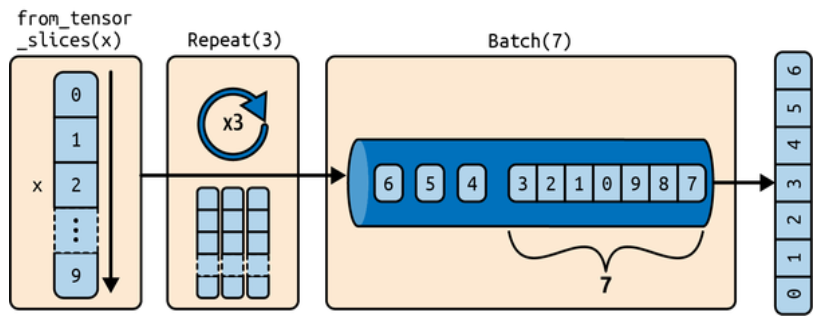

### Shuffling the Data
Graadient Descent works the best when the instances in the training set are independent and identically distribution (IID). A simple way to ensure this is to shuffle the instances using the `shuffle` method. It will create a new dataset that will start by filling up a bufferwith the first items of the source dataset. Then, whenever it is asked for an item,it will pull one out randomly and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset. At this point, it will continue to pull out items randomly fromthe buffer until its empty.

For example, the following code creates and displays a dataset containing the integers 0 to 9, repeated twice, shuffled using a buffer of size 4 and a random seed of 42, batched with a batch size of 7:

In [3]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
  print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


### Interleaving Lines from Multiple Files
Start by loading and preparing the California Housing dataset. We first load it, then split it into a training set, a validation set and a test set:

In [4]:
# Fetches, splits and normalizes the California housing dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

For a very large dataset that does not fit in memory, we will typically split it into many files first, then have TensorFlow to read these files in parallel. The following code splits the housing dataset and saves it to 20 CSV files:

In [5]:
# Split the dataset into 20 parts and save it to CSV files
import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

Take a peek at the first few lines of 1 of those CSV files:

In [6]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



Suppose `train_filepaths` contains the list of training filepaths:

In [7]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

By default, the `list_files` function returns a dataset that shuffles the filepaths. This is generally a good thing, but to get an unshuffled filepath, set `shuffle=False`.

Next, the `interleave` method can be called to read 5 files at a time and interleave their lines. The first line of each file, which is usually the header row, can be skipped using the `skip` method:

In [8]:
n_readers = 5

dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers
)

### Preprocessing the Data
Now that we have a housing dataset that returns each instance as a tensor
containing a byte string, we need to do a bit of preprocessing, including
parsing the strings and scaling the data. Implement a couple custom
functions that will perform this preprocessing:

In [9]:
# Compute the mean and standard deviation of each feature
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [10]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

Test the preprocessing function:

In [11]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

The preprocessing function looks good, it is able to convert an instance from a byte string to a nice scaled tensor, with its corresponding label.

###Putting Everything Together
To make the code more reusable, put everything together into another helper function, which will create and return a dataset that will efficiently load California housing data from multiple CSV files, preprocess it, shuffle it and batch it:

In [12]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

By calling `prefetch` at the end of the function, a new dataset is created which will do its best to always be 1 batch ahead. In other words, while the training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready. This will improve performance drastically.

###Using the Dataset with Keras
Using the custom `csv_reader_dataset` function created above, a dataset for the training set, validation set and test set can be created.The training set will be shuffled at each epoch:

In [13]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

Now a Keras model can be built and trained using these datasets.


In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
    359/Unknown 4s 4ms/step - loss: 1.2313

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.2282 - val_loss: 2347.0571
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 5.6467 - val_loss: 1.8108
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.6479 - val_loss: 0.4970
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.4730 - val_loss: 0.3993
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.4346 - val_loss: 0.4219


## Keras Preprocessing Layers
Preparing data for a neural network typically requires Normalizing the numerical features, Encoding the categorical features and text, Cropping and Resizing images and more. There are several options to do so:
- Preprocessing can be done ahead of time, when preparing training data files, using any tools preferred, such as Numpy, Pandas or Sci-kit Learn. The exact samepreprocessing stepsin production must be applied to ensure that the production model receives preprocessed inputs similar to the ones it was trained on.
- Alternatively, the data can be preprocessed while loading it with `tf.data`, by applying a preprocessing function to every element of a dataset using that dataset's `map` method. Similarly, the same preprocessing steps must be applied.
- Last approach is to include preprocessing layers directly inside the model, then use the same preprocessing layers in production.

Keras offers many preprocessing layers that can be including into modelsl:
###1) Normalization Layer:
Keras provides a *Normalization Layer* that can be used to standardize the input features. We can either specify the mean and variance of each feature when creating the layer or more simply, pass the training set to the layer's `adapt` method before fitting the model so the layer can measure the feature means and variances on its own before training:

In [16]:
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train) # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 3.8879 - val_loss: 2.0485
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.9170 - val_loss: 0.7804
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7337 - val_loss: 0.8034
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6908 - val_loss: 0.7609
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.6635 - val_loss: 0.7323


Including the preprocessing layer directly in the model is straightforward, but it will slow down training. We can do better by normalizing the whole training set before training. To do this, we can use the Normlization layer in a standalone fashion:

In [17]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

Now we can train a model on the scaled data, this time without a Normalization layer:

In [18]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.7777 - val_loss: 1.3370
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7804 - val_loss: 0.6519
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6257 - val_loss: 0.6708
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6039 - val_loss: 0.6540
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5931 - val_loss: 0.6429


The model will not preprocess its inputs when we deploy it to production. TO fix this, we just need to create a new model that wraps both the Normlization layer and the model we just trained:

In [19]:
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3] # pretend we have a few new instances (unscaled)
y_pred = final_model(X_new) # preprocesses the data and makes predictions

### Discretization Layer
Goal of this layer is to transform a numerical feature into a categorical feature by mapping value ranges (called bins) to categories. This is sometimes useful for features with multimodal distributions, or with features that have a highly non-linear relationship with the target.

For example, the following codemaps a numerical age feature to 3 categories (less than 18, between 18 to 50 (not included), 50 or above):

In [20]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

In the following example, we set `num_bins=3`, then the bin boundaries will be located at the values just below the 33rd and 66th percentiles:

In [21]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

###CategoryEncoding Layer
When there are only a few categories, then one-hot encoding is often a good option. Example:

In [22]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

However, if trying to encode more than 1 categorical feature at a time, the `CategoryEncoding` class will perform multi-hot encoding by default:

In [23]:
two_age_categories = np.array([[1,0], [2,2], [2,0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

### StringLookup Layer
Using the Keras `StringLookup` to one-hot encode a cities feature:

In [24]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]])>

How the above code works:

1) Create a `StringLookup` layer, then we adapt it to the data.<br>
2) Then we use the layer to encode a few cities.<br>
3) By default, they are encoded as integers, unknown categories get mapped to 0, as is the case for "Montreal" in this example.

### Hashing Layer
For each category, the Keras Hashing layer computes a hash, modulo the number of buckets (or "bins"). For example, using the Hashing layer to encode a few cities:

In [25]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]])>

In this example, we get a hashing collision: "Tokyo" and "Montreal", where they are mapped to the same ID, making them indistinguishable by the model.  So, it's usually preferable to stick to the `StringLookup` layer.

### Encoding Categorical Features using Embeddings
An **Embedding** is a dense representation of some higher-dimensional data, such as a category or a word in a vocabulary. If there are 50,000 possible categories, then one-hot encoding would produce a 50,000-dimensional sparse vector (containing mostly zeros). In contrast, an embedding would be a smaller dense vector; for example, with just 100 dimensions.

Keras provides an `Embedding` layer. By default, it is initialized randomly. For example, to initialize an `Embedding` layer with 5 rows and 2D embeddings, and use it to encode some categories:

In [26]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2,4,2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.03248113, -0.00599519],
       [ 0.02185174, -0.03314891],
       [-0.03248113, -0.00599519]], dtype=float32)>

Since the layer is not trained yet, these encodings are just random.

To embed a categorical text attribute, simply chain a `StringLookup` layer and an `Embedding` layer, like:

In [27]:
tf.random.set_seed(42)

ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),  # WORKAROUND
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.02192482, -0.00244373],
       [ 0.02387223,  0.04016724],
       [ 0.02192482, -0.00244373]], dtype=float32)>

Putting everything together, we can now create a Keras model that can process a categorical text feature along with regular numerical features and learn an embedding for each category:

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000).astype(object)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000).astype(object)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1926 - val_loss: 0.1287
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1216 - val_loss: 0.1025
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0993 - val_loss: 0.0923
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0903 - val_loss: 0.0880
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0865 - val_loss: 0.0859


This model takes 2 inputs: `num_input`, which contains 8 numerical features per instance and `cat_input`, which contains a single categorical text input per instance.

### Text Preprocessing
Keras provides a `TextVectorization` layer for basic text preprocessing. Much like the `StringLookup` layer, we must either pass it a vocabulary upon creation or let it learn the vocabulary from some training data using the `adapt` method. Example:

In [29]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]])>

The 2 sentences "Be good!" and "Question: be or be?" were encoded as [2, 1, 0, 0] and [6, 2, 1, 2] respectively. The vocabulary was learned from the 4 sentences in the training data: "be"=2, "or"=1, etc.

Alternatively, `TextVectorization` layer's `output_mode` argument can be set to "multi_hot" or "count" to get the corresponding encodings. However, simply counting words is usually not ideal: words like "to" and "the" are so frequent that they hardly matter at all. So, rather than setting `output_mode` to "multi_hot" or "count", it is usually preferable to set it to "tf_idf", which stands for *term-frequency x inverse-document-frequency* (TF-IDF). For example:

In [30]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

There are many TF-IDF variants, but the way the `TextVectorization`
layer implements it is by multiplying each word count by a weight equal to
log(1 + d / (f + 1)), where d is the total number of sentences (a.k.a.,
documents) in the training data and f counts how many of these training
sentences contain the given word. For example, in this case there are d = 4
sentences in the training data, and the word “be” appears in f = 3 of these.
Since the word “be” occurs twice in the sentence “Question: be or be?”, it
gets encoded as 2 × log(1 + 4 / (1 + 3)) ≈ 1.3862944. The word “question”
only appears once, but since it is a less common word, its encoding is
almost as high: 1 × log(1 + 4 / (1 + 1)) ≈ 1.0986123. Note that the average
weight is used for unknown words.

## TensorFlow Datasets (TFDS) Project
TFDS project makes it easy to load common datasets, from small to huge datasets. Note that TFDS is not bundled with TensorFlow. For example, let's download MNIST:

In [31]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

Transformations is now ready to be applied and the model is ready to be trained. Example:

In [32]:
for batch in mnist_train.shuffle(10_000, seed=42).batch(32).prefetch(1):
    images = batch["image"]
    labels = batch["label"]
    # [...] do something with the images and labels

Note that each item in the dataset is a dictionary containing both the features and the labels. But Keras expects each item to be a tuple containing 2 elements: once again, the features and the labels. The dataset can be transformed using `map` method:

In [33]:
mnist_train = mnist_train.shuffle(buffer_size=10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

Lastly, TFDS provides a convenient way to split the data using the `split` argument. For example, if we want to use the first 90% of the training set for training, the remaining 10% for validation and the whole of the testing set for testing, we can set `split=["train[:90%]", "train[90%:]", "test"]. The `load` function will return all 3 sets. The following code first loads, then splits the MNIST dataset using TFDS, and finally use these sets to train and evaluate a simple Keras model:

In [34]:
train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7561 - loss: 19.3411 - val_accuracy: 0.8780 - val_loss: 6.6786
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8775 - loss: 5.7605 - val_accuracy: 0.8887 - val_loss: 5.5559
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8835 - loss: 5.2186 - val_accuracy: 0.8692 - val_loss: 6.3685
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8864 - loss: 4.9809 - val_accuracy: 0.8830 - val_loss: 5.6079
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8895 - loss: 4.8493 - val_accuracy: 0.8890 - val_loss: 5.6425
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8932 - loss: 5.0423
